In [ ]:
#for detecting my GPU local machine
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# List available physical devices (GPUs)
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPUs detected:", gpus)
    # Optionally, set memory growth to avoid TensorFlow allocating all GPU memory
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPUs detected")


2025-02-06 14:46:04.375148: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 14:46:04.511054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738853164.570820   49131 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738853164.586046   49131 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 14:46:04.715254: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#for Google Colab
#from google.colab import drive
#drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
from sklearn.utils import class_weight


In [ ]:
# Creating Fish Classification class

class FishClassifier:
    def __init__(self, img_size=(224, 224), batch_size=32):
        self.img_size = img_size
        self.batch_size = batch_size
        self.history = None
        self.model = None

    def create_data_generators(self, data_dir):
        """Create train and validation data generators with augmentation"""
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2
        )

        train_generator = train_datagen.flow_from_directory(
            data_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='training'
        )

        validation_generator = train_datagen.flow_from_directory(
            data_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='validation'
        )

        return train_generator, validation_generator

    def build_custom_cnn(self, num_classes):
        """Build a custom CNN model"""
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(*self.img_size, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),

            Conv2D(128, (3, 3), activation='relu'),
            #MaxPooling2D((2, 2)),
            #Conv2D(256, (3, 3), activation='relu'),
            Flatten(),
            Dense(256, activation='relu'),
            #Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
        return model

    def build_transfer_learning_model(self, base_model_name, num_classes):
        """Build a transfer learning model using pre-trained networks"""
        base_models = {
            'VGG16': VGG16,
            'ResNet50': ResNet50,
            'MobileNet': MobileNet,
            'InceptionV3': InceptionV3,
            'EfficientNetB0': EfficientNetB0
        }

        base = base_models[base_model_name](
            weights='imagenet',
            include_top=False,
            input_shape=(*self.img_size, 3)
        )

        # Freeze base model layers
        base.trainable = False

        model = Sequential([
            base,
            Flatten(),
            Dense(256, activation='relu'),
            #Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

        return model

    def train_model(self, model, train_generator, validation_generator, epochs=10):

        #class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_generator), y=train_generator)

        #model.fit(X_train, y_train, epochs=10, class_weight=class_weights)

        early_stopping = EarlyStopping(
                                        monitor='val_loss',        # Monitor validation loss
                                        patience=3,                # Stop after 3 epochs with no improvement
                                        #min_delta=0.001,           # Minimum change to qualify as an improvement
                                        restore_best_weights=True  # Restore the best model weights when training stops
                                    )
        """Train the model and return history"""
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        self.history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=[early_stopping] #,
            #class_weight=class_weights
        )

        self.model = model
        return self.model, self.history

    def evaluate_model(self, test_generator):
        """Evaluate model and return metrics"""
        predictions = self.model.predict(test_generator)
        y_pred = np.argmax(predictions, axis=1)
        y_true = test_generator.classes

        report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys(),output_dict=True)
        conf_matrix = confusion_matrix(y_true, y_pred)

        return report, conf_matrix

    def plot_training_history(self):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        ax1.plot(self.history.history['accuracy'])
        ax1.plot(self.history.history['val_accuracy'])
        ax1.set_title('Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(['Train', 'Validation'])

        ax2.plot(self.history.history['loss'])
        ax2.plot(self.history.history['val_loss'])
        ax2.set_title('Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(['Train', 'Validation'])

        plt.tight_layout()
        return fig

    def save_model(self, filepath):
        """Save the trained model"""
        self.model.save(filepath)

    def load_model(self, filepath):
        """Load a trained model"""
        self.model = tf.keras.models.load_model(filepath)


In [ ]:
# Creating object for class
classifier = FishClassifier()


PATH ='data/train'
epochs=20

# Load data
train_gen, val_gen = classifier.create_data_generators(PATH)
num_classes = len(train_gen.class_indices)
model_results = {}

Found 4960 images belonging to 10 classes.
Found 1235 images belonging to 10 classes.


/home/k7/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1738853378.865511   49131 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5660 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/k7/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1738853381.333099   50130 service.cc:148] XLA service 0x7f4e180167e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738853381.333648   50130 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2025-02-06 14:49:41.367845: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738853381.513607   50130 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/155 ━━━━━━━━━━━━━━━━━━━━ 16:43 7s/step - accuracy: 0.1250 - loss: 2.2969

I0000 00:00:1738853386.422349   50130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


139/155 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - accuracy: 0.2780 - loss: 3.2142 

2025-02-06 14:50:28.072467: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng33{k2=2,k6=2,k13=1,k14=0,k22=2} for conv (f32[32,64,109,109]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,111,111]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-02-06 14:50:28.089616: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 5.785672588s
Trying algorithm eng33{k2=2,k6=2,k13=1,k14=0,k22=2} for conv (f32[32,64,109,109]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,111,111]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBia

155/155 ━━━━━━━━━━━━━━━━━━━━ 52s 296ms/step - accuracy: 0.2911 - loss: 3.0768 - val_accuracy: 0.5287 - val_loss: 1.2772
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 49s 318ms/step - accuracy: 0.5597 - loss: 1.1927 - val_accuracy: 0.6923 - val_loss: 0.7953
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 44s 285ms/step - accuracy: 0.7112 - loss: 0.8141 - val_accuracy: 0.7077 - val_loss: 0.8501
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 54s 273ms/step - accuracy: 0.7760 - loss: 0.6428 - val_accuracy: 0.8397 - val_loss: 0.4402
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 43s 274ms/step - accuracy: 0.8161 - loss: 0.5240 - val_accuracy: 0.8340 - val_loss: 0.4741
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 42s 273ms/step - accuracy: 0.8477 - loss: 0.4104 - val_accuracy: 0.8850 - val_loss: 0.3207
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 43s 276ms/step - accuracy: 0.8771 - loss: 0.3575 - val_accuracy: 0.8632 - val_loss: 0.3878
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 43s 240ms/step - accuracy: 0.8865 - loss: 0.3167 - val

39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step


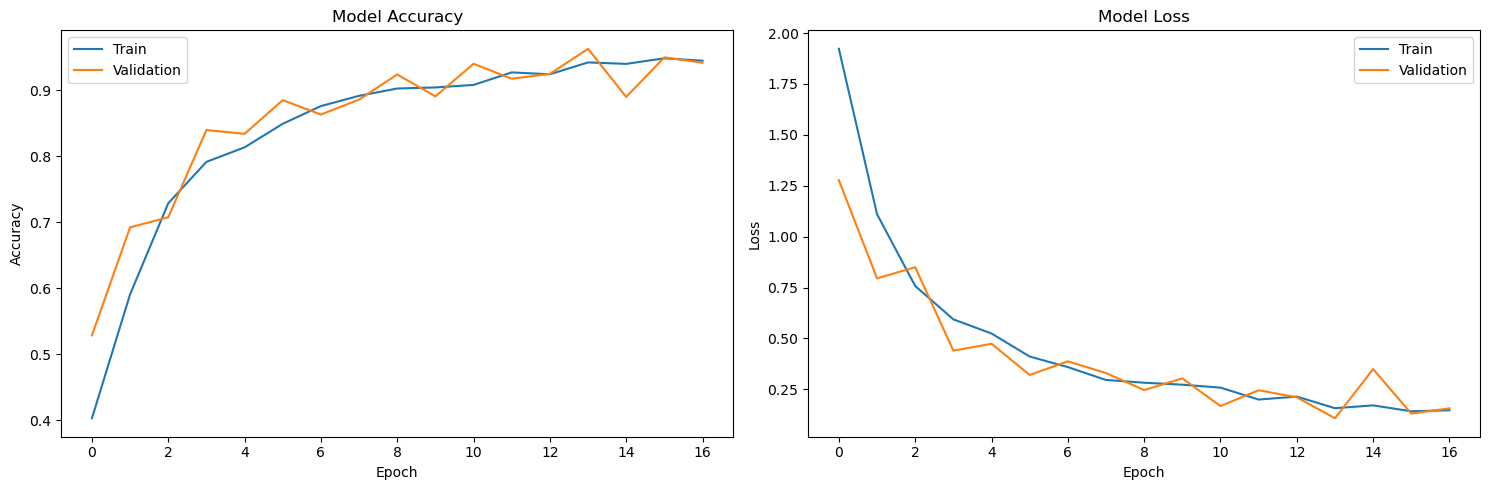

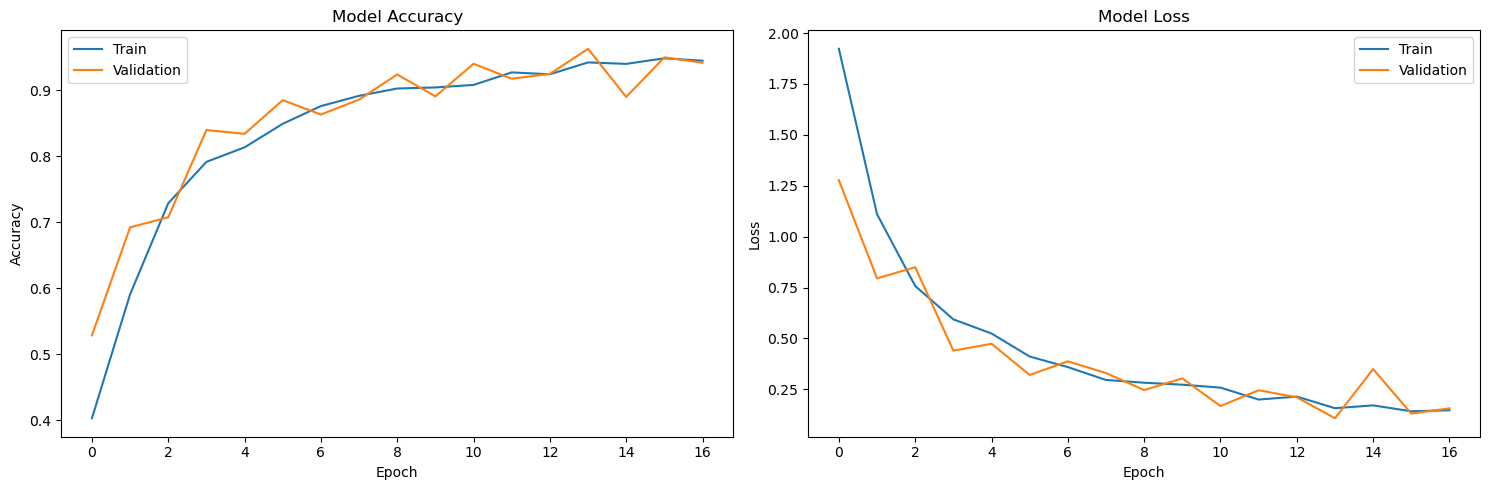

In [ ]:
# Train Custom CNN Model

cnn_model = classifier.build_custom_cnn(num_classes)
cnn_custom_model, cnn_history = classifier.train_model(cnn_model, train_gen, val_gen,epochs=epochs)
cnn_custom_model.save('fish classification models saved'+'CNN_Custom_model.h5')
report, conf_matrix = classifier.evaluate_model(val_gen)


model_results['CNN_Custom'] = {
    'history': cnn_history,
    'report': report,
    'conf_matrix': conf_matrix
}

#Visualize train vs validation data
classifier.plot_training_history()




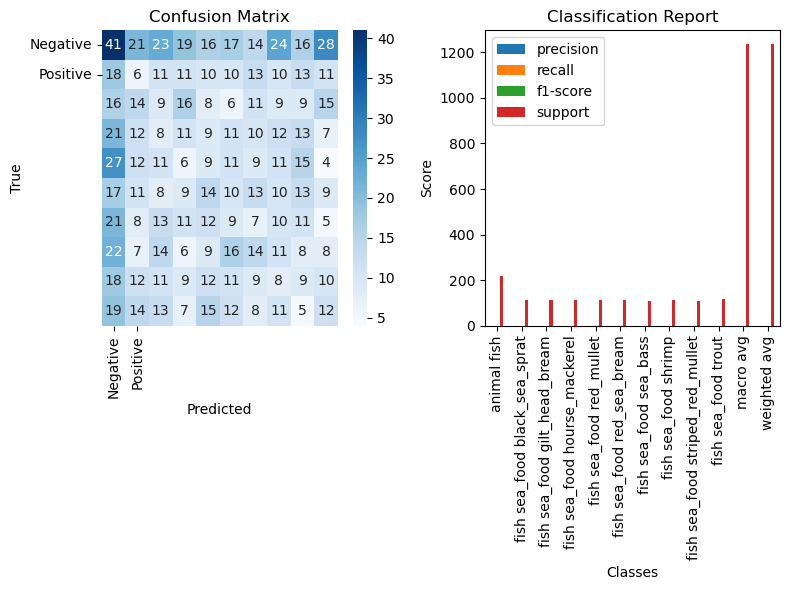

In [ ]:
#Visualize Confusion matrix and Classification report
report_df = pd.DataFrame(report).transpose()

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

# Classification Report
report_df.drop('accuracy', axis=0).plot(kind='bar', ax=ax[1], figsize=(8, 6))
ax[1].set_title('Classification Report')
ax[1].set_ylabel('Score')
ax[1].set_xlabel('Classes')

plt.tight_layout()
plt.show()

In [ ]:
# Train Transfer learning models using VGG16
models_to_try = ['VGG16', 'ResNet50', 'MobileNet', 'InceptionV3', 'EfficientNetB0']

model_name='VGG16'

#for model_name in models_to_try:
model = classifier.build_transfer_learning_model(model_name, num_classes)
out_model, history = classifier.train_model(model, train_gen, val_gen,epochs=epochs)
out_model.save('fish classification models saved'+model_name+'_model.h5')
report, conf_matrix = classifier.evaluate_model(val_gen)
model_results[model_name] = {
    'history': history,
    'report': report,
    'conf_matrix': conf_matrix
}

classifier.plot_training_history()

I0000 00:00:1738848403.082554   33441 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/k7/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1738848405.054568   43675 service.cc:148] XLA service 0x7fada801e770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738848405.054943   43675 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2025-02-06 13:26:45.077683: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738848405.278073   43675 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-06 13:26:48.820789: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng33{k2=2,k6=2,k13=1,k14=0,k22=0} for conv (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"act

  1/156 ━━━━━━━━━━━━━━━━━━━━ 34:51 13s/step - accuracy: 0.0625 - loss: 2.9916

I0000 00:00:1738848417.934117   43675 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


123/156 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - accuracy: 0.4501 - loss: 2.4503 

2025-02-06 13:27:35.799748: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng13{} for conv (f32[24,128,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,64,112,112]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-02-06 13:27:35.821323: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 5.770358495s
Trying algorithm eng13{} for conv (f32[24,128,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,64,112,112]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", bac

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.4961 - loss: 2.1948

2025-02-06 13:27:55.834086: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=2,k4=1,k5=0,k6=0,k7=0,k19=0} for conv (f32[25,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-02-06 13:27:55.860849: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 5.684960183s
Trying algorithm eng20{k2=2,k4=1,k5=0,k6=0,k7=0,k19=0} for conv (f32[25,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custo

156/156 ━━━━━━━━━━━━━━━━━━━━ 70s 367ms/step - accuracy: 0.4973 - loss: 2.1883 - val_accuracy: 0.8751 - val_loss: 0.4349
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - accuracy: 0.8881 - loss: 0.3812 - val_accuracy: 0.8944 - val_loss: 0.3174
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 49s 314ms/step - accuracy: 0.9283 - loss: 0.2343 - val_accuracy: 0.9162 - val_loss: 0.2388
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 47s 299ms/step - accuracy: 0.9411 - loss: 0.1975 - val_accuracy: 0.9210 - val_loss: 0.2335
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.9401 - loss: 0.1878 - val_accuracy: 0.9307 - val_loss: 0.2023
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - accuracy: 0.9434 - loss: 0.1585 - val_accuracy: 0.9573 - val_loss: 0.1341
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 44s 280ms/step - accuracy: 0.9657 - loss: 0.1113 - val_accuracy: 0.9371 - val_loss: 0.1770
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 43s 237ms/step - accuracy: 0.9559 - loss: 0.1381 - val

39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step


NameError: name 'model_results' is not defined

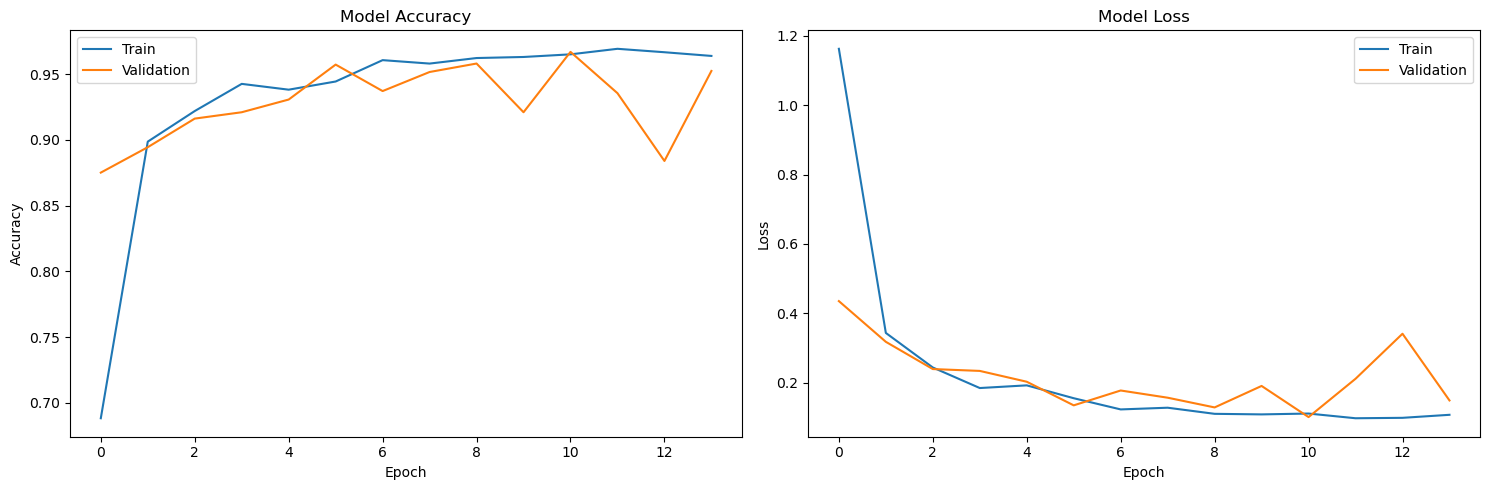

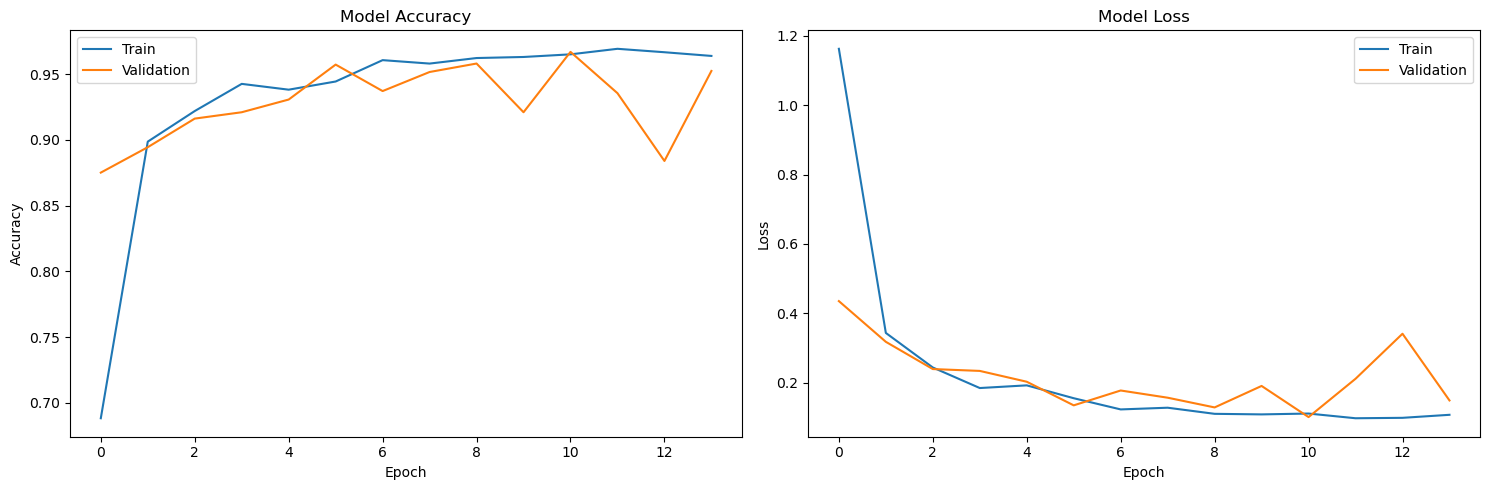

In [ ]:
model_results[model_name] = {
    'history': history,
    'report': report,
    'conf_matrix': conf_matrix
}

classifier.plot_training_history()

Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 61s 330ms/step - accuracy: 0.1249 - loss: 4.2673 - val_accuracy: 0.1757 - val_loss: 2.3778
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 44s 280ms/step - accuracy: 0.1710 - loss: 2.3938 - val_accuracy: 0.1765 - val_loss: 2.3602
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 43s 275ms/step - accuracy: 0.1725 - loss: 2.3815 - val_accuracy: 0.1765 - val_loss: 2.3471
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 44s 282ms/step - accuracy: 0.1639 - loss: 2.3697 - val_accuracy: 0.1765 - val_loss: 2.3370
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 44s 285ms/step - accuracy: 0.1783 - loss: 2.3335 - val_accuracy: 0.1765 - val_loss: 2.3292
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 42s 265ms/step - accuracy: 0.1788 - loss: 2.3269 - val_accuracy: 0.1765 - val_loss: 2.3232
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 45s 286ms/step - accuracy: 0.1722 - loss: 2.3250 - val_accuracy: 0.1765 - val_loss: 2.3185
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 41s 264ms/step - accuracy: 0.1701 - loss: 2

39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 294ms/step


/home/k7/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/k7/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/k7/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


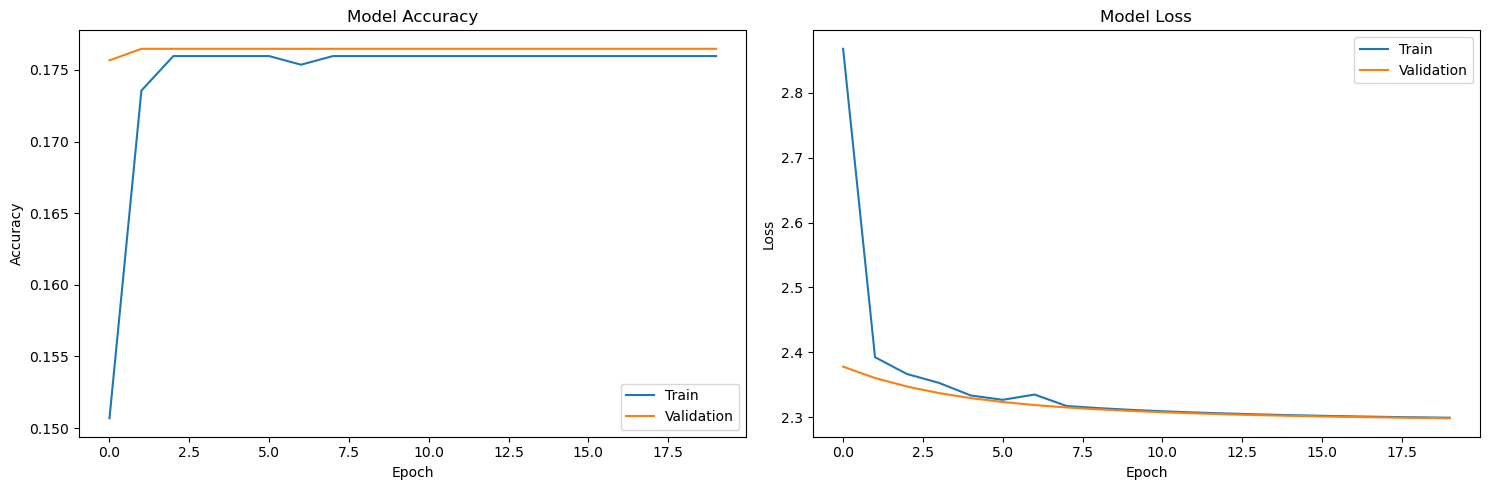

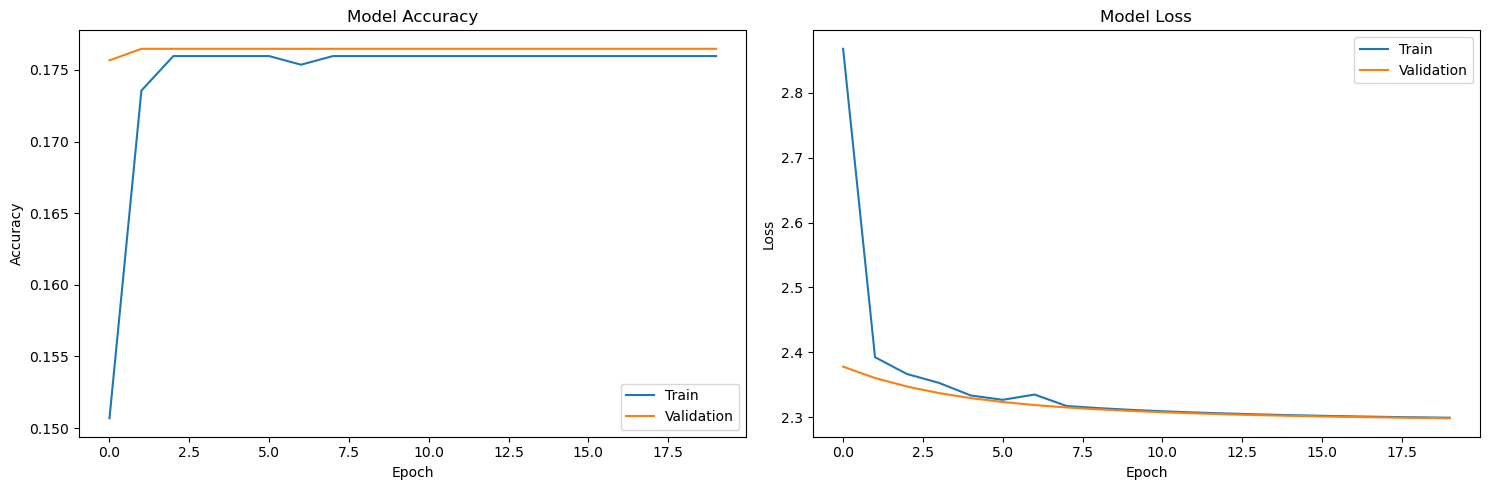

In [ ]:
# Train Transfer learning models using ResNet50

models_to_try = ['VGG16', 'ResNet50', 'MobileNet', 'InceptionV3', 'EfficientNetB0']

model_name='ResNet50'

#for model_name in models_to_try:
model = classifier.build_transfer_learning_model(model_name, num_classes)
out_model, history = classifier.train_model(model, train_gen, val_gen,epochs=epochs)
out_model.save('fish classification models saved'+model_name+'_model.h5')
report, conf_matrix = classifier.evaluate_model(val_gen)
model_results[model_name] = {
    'history': history,
    'report': report,
    'conf_matrix': conf_matrix
}


classifier.plot_training_history()

Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 57s 323ms/step - accuracy: 0.3141 - loss: 9.0763 - val_accuracy: 0.7236 - val_loss: 0.9307
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 44s 283ms/step - accuracy: 0.5194 - loss: 1.3820 - val_accuracy: 0.7671 - val_loss: 0.6532
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 41s 262ms/step - accuracy: 0.5572 - loss: 1.2012 - val_accuracy: 0.8163 - val_loss: 0.5642
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 43s 276ms/step - accuracy: 0.6157 - loss: 1.0095 - val_accuracy: 0.9251 - val_loss: 0.3205
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 49s 312ms/step - accuracy: 0.6420 - loss: 0.9227 - val_accuracy: 0.9065 - val_loss: 0.3117
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 37s 237ms/step - accuracy: 0.6557 - loss: 0.9076 - val_accuracy: 0.9057 - val_loss: 0.3732
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - accuracy: 0.6722 - loss: 0.8691 - val_accuracy: 0.9331 - val_loss: 0.2223
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 45s 286ms/step - accuracy: 0.7015 - loss: 0

39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 263ms/step


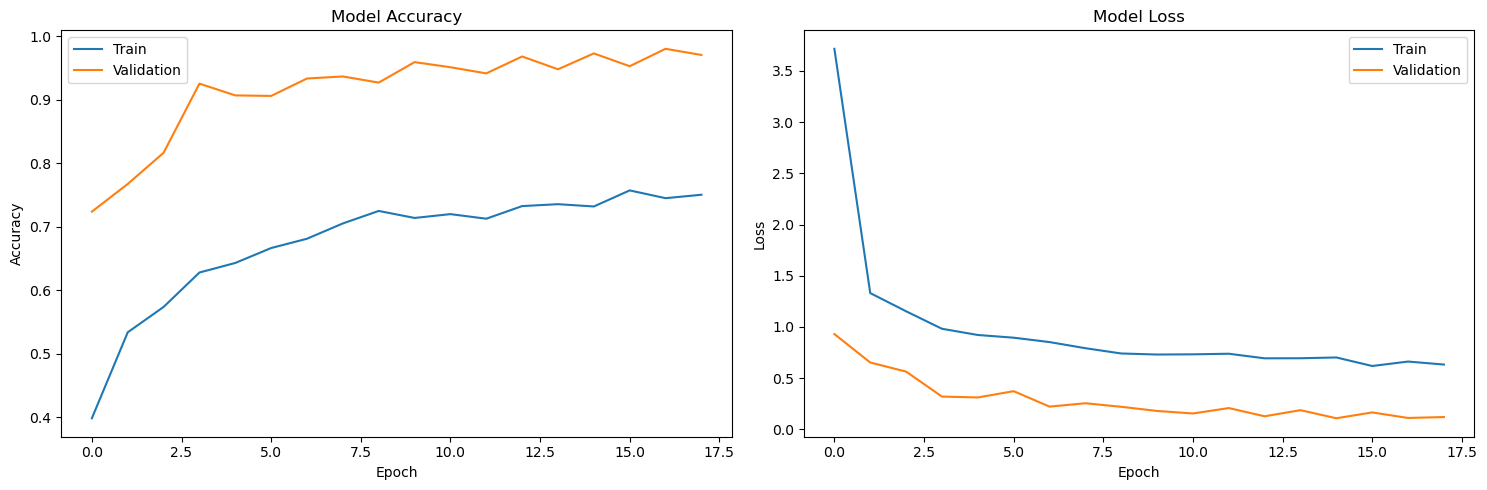

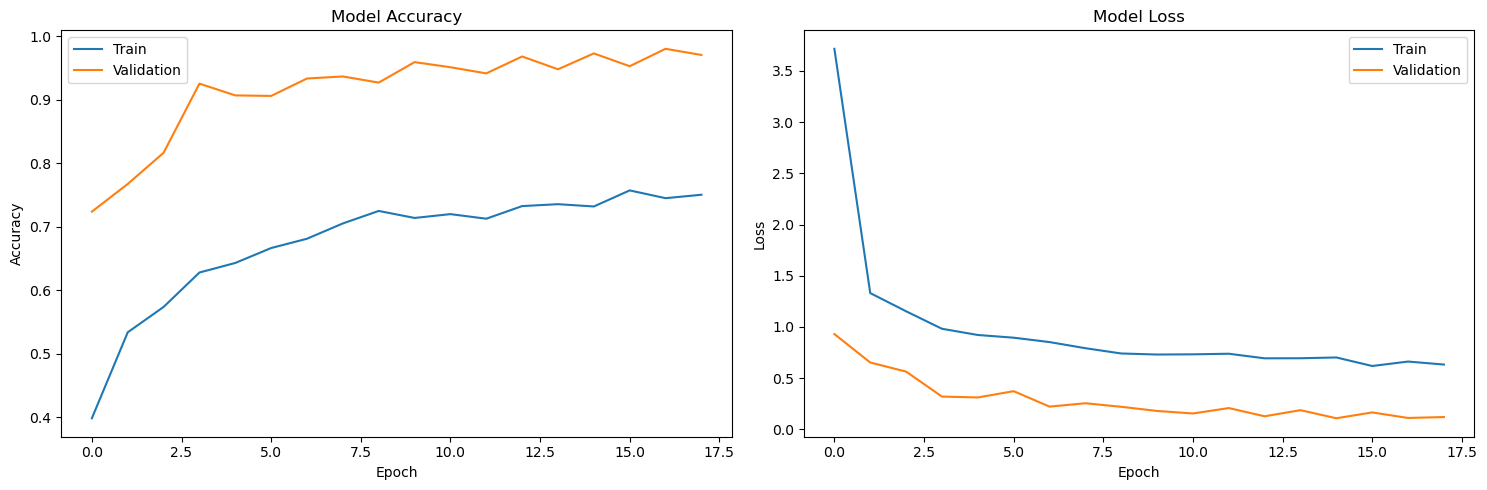

In [ ]:
# Train Transfer learning models using MobileNet

models_to_try = ['VGG16', 'ResNet50', 'MobileNet', 'InceptionV3', 'EfficientNetB0']

model_name='MobileNet'

#for model_name in models_to_try:
model = classifier.build_transfer_learning_model(model_name, num_classes)
out_model, history = classifier.train_model(model, train_gen, val_gen,epochs=epochs)
out_model.save('fish classification models saved'+model_name+'_model.h5')
report, conf_matrix = classifier.evaluate_model(val_gen)
model_results[model_name] = {
    'history': history,
    'report': report,
    'conf_matrix': conf_matrix
}

classifier.plot_training_history()

Epoch 1/20


2025-02-06 07:58:35.418876: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng53{k2=1,k13=0,k14=3,k18=0,k23=0} for conv (f32[32,192,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,12,12]{3,2,1,0}, f32[192,128,1,7]{3,2,1,0}), window={size=1x7 pad=0_0x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-02-06 07:58:35.419298: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 5.431568876s
Trying algorithm eng53{k2=1,k13=0,k14=3,k18=0,k23=0} for conv (f32[32,192,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,12,12]{3,2,1,0}, f32[192,128,1,7]{3,2,1,0}), window={size=1x7 pad=0_0x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backe

138/156 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - accuracy: 0.2682 - loss: 12.1997

2025-02-06 07:59:15.485814: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng58{k25=2} for conv (f32[24,80,54,54]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,64,54,54]{3,2,1,0}, f32[80,64,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-02-06 07:59:15.489734: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 5.005355823s
Trying algorithm eng58{k25=2} for conv (f32[24,80,54,54]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,64,54,54]{3,2,1,0}, f32[80,64,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result

156/156 ━━━━━━━━━━━━━━━━━━━━ 81s 437ms/step - accuracy: 0.2759 - loss: 11.2928 - val_accuracy: 0.5399 - val_loss: 1.2559
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 41s 263ms/step - accuracy: 0.4018 - loss: 1.6064 - val_accuracy: 0.6938 - val_loss: 0.9311
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 46s 295ms/step - accuracy: 0.4848 - loss: 1.3290 - val_accuracy: 0.7381 - val_loss: 0.7655
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 42s 265ms/step - accuracy: 0.5127 - loss: 1.2688 - val_accuracy: 0.7720 - val_loss: 0.7254
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 44s 283ms/step - accuracy: 0.5224 - loss: 1.2360 - val_accuracy: 0.8050 - val_loss: 0.7060
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 44s 246ms/step - accuracy: 0.5485 - loss: 1.1838 - val_accuracy: 0.7824 - val_loss: 0.6793
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 44s 280ms/step - accuracy: 0.5525 - loss: 1.1390 - val_accuracy: 0.8251 - val_loss: 0.6652
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 45s 291ms/step - accuracy: 0.5698 - loss: 1.1187 - va

39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 303ms/step


/home/k7/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/k7/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/k7/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


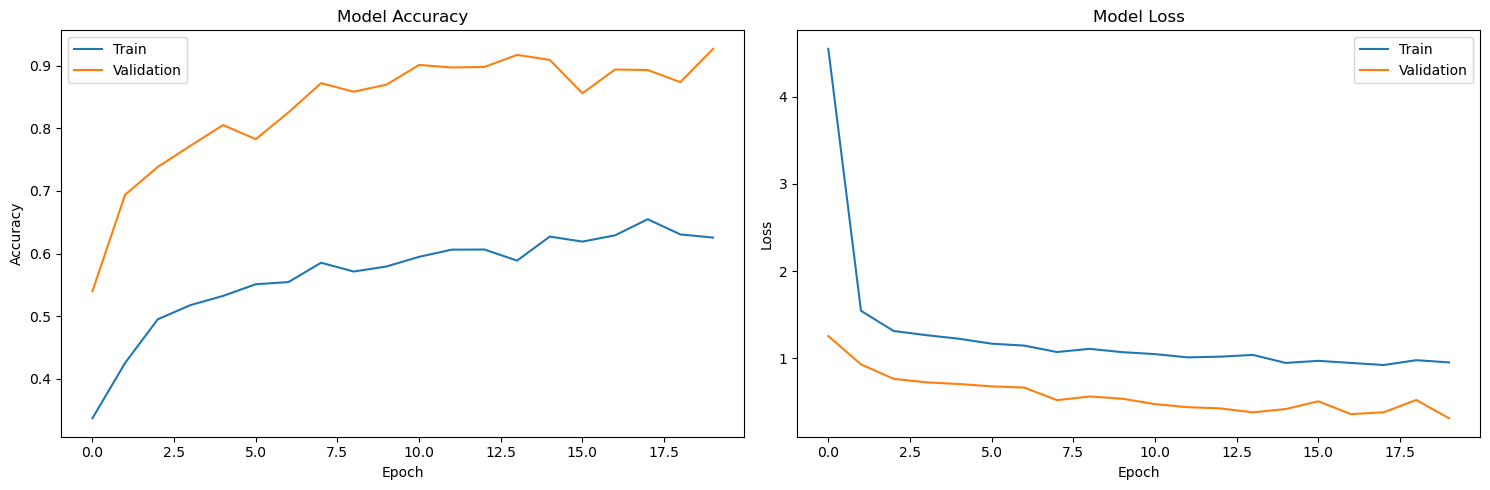

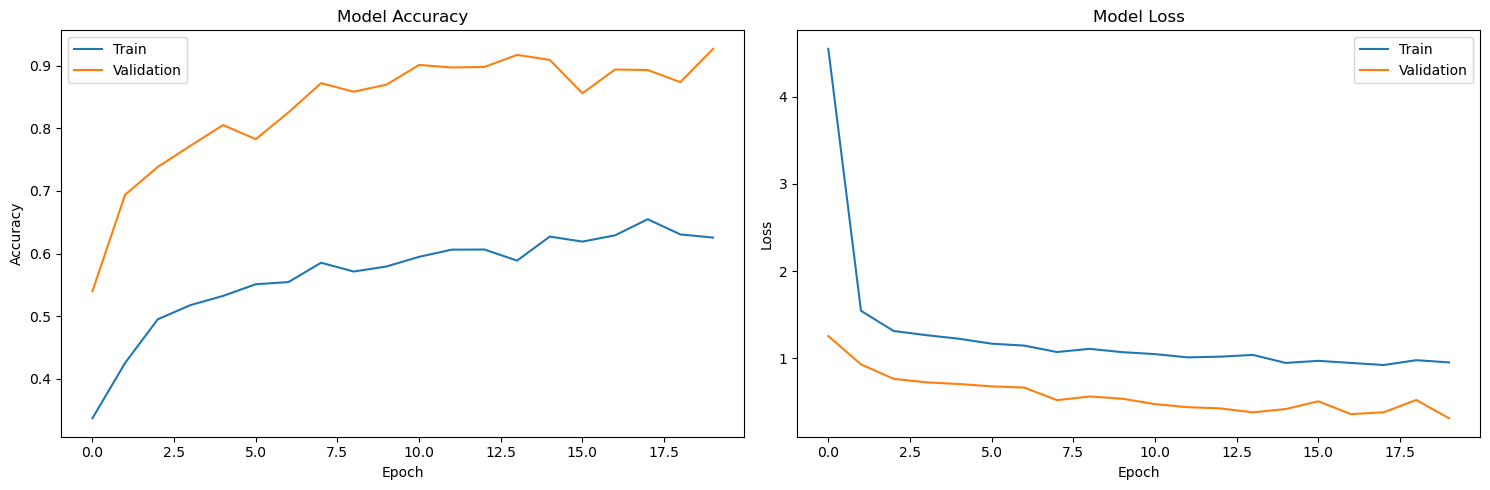

In [ ]:
# Train Transfer learning models using InceptionV3

models_to_try = ['VGG16', 'ResNet50', 'MobileNet', 'InceptionV3', 'EfficientNetB0']

model_name='InceptionV3'

#for model_name in models_to_try:
model = classifier.build_transfer_learning_model(model_name, num_classes)
out_model, history = classifier.train_model(model, train_gen, val_gen,epochs=epochs)
out_model.save('fish classification models saved'+model_name+'_model.h5')
report, conf_matrix = classifier.evaluate_model(val_gen)
model_results[model_name] = {
    'history': history,
    'report': report,
    'conf_matrix': conf_matrix
}


classifier.plot_training_history()

Epoch 1/20
 16/156 ━━━━━━━━━━━━━━━━━━━━ 32s 234ms/step - accuracy: 0.1352 - loss: 13.9796

2025-02-06 08:14:21.821975: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng55{k2=3,k13=0,k14=1,k18=0,k22=0,k23=0} for conv (f32[24,24,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,96,56,56]{3,2,1,0}, f32[24,96,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-02-06 08:14:21.824345: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 5.040451229s
Trying algorithm eng55{k2=3,k13=0,k14=1,k18=0,k22=0,k23=0} for conv (f32[24,24,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,96,56,56]{3,2,1,0}, f32[24,96,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_co

139/156 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.1340 - loss: 5.6367 

2025-02-06 08:15:11.900918: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[25,28,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,672,1,1]{3,2,1,0}, f32[28,672,1,1]{3,2,1,0}, f32[28]{0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-02-06 08:15:11.904046: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 5.028760208s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[25,28,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,672,1,1]{3,2,1,0}, f32[28,672,1,1]{3,2,1,0}, f32[28]{0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv

156/156 ━━━━━━━━━━━━━━━━━━━━ 73s 361ms/step - accuracy: 0.1368 - loss: 5.3619 - val_accuracy: 0.1765 - val_loss: 2.3789
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 43s 276ms/step - accuracy: 0.1834 - loss: 2.3806 - val_accuracy: 0.1765 - val_loss: 2.3619
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 44s 279ms/step - accuracy: 0.1730 - loss: 2.3679 - val_accuracy: 0.1765 - val_loss: 2.3487
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 43s 277ms/step - accuracy: 0.1808 - loss: 2.3452 - val_accuracy: 0.1765 - val_loss: 2.3382
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 43s 276ms/step - accuracy: 0.1712 - loss: 2.3384 - val_accuracy: 0.1765 - val_loss: 2.3302
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - accuracy: 0.1674 - loss: 2.3329 - val_accuracy: 0.1765 - val_loss: 2.3239
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 43s 275ms/step - accuracy: 0.1695 - loss: 2.3262 - val_accuracy: 0.1765 - val_loss: 2.3190
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 43s 275ms/step - accuracy: 0.1742 - loss: 2.3180 - val

39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 448ms/step


/home/k7/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/k7/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/k7/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


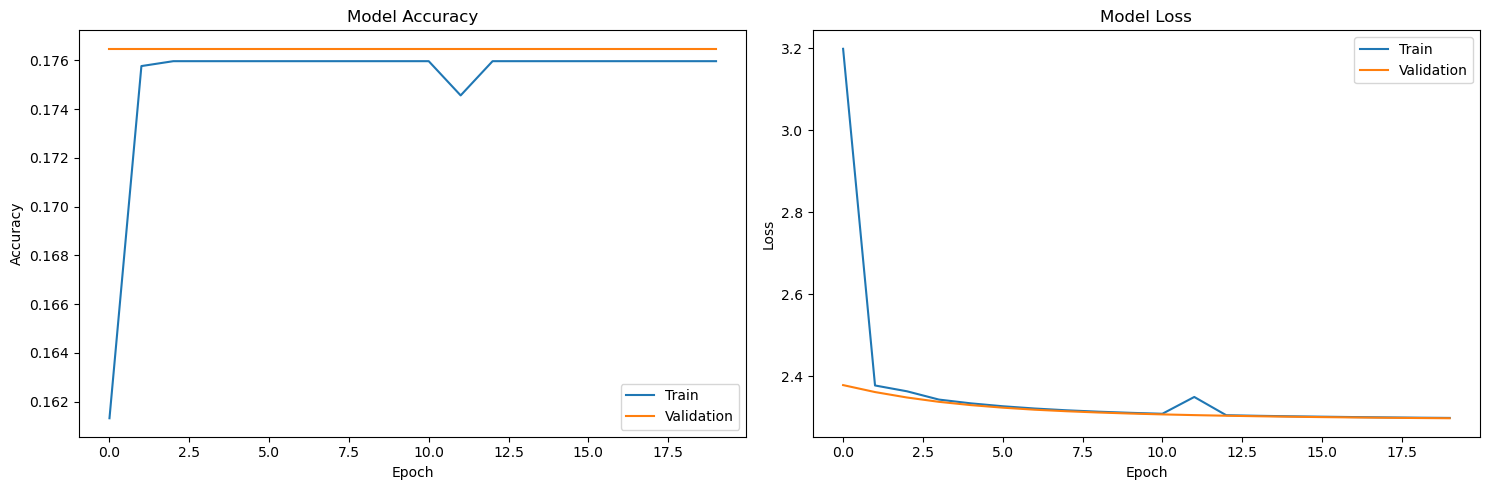

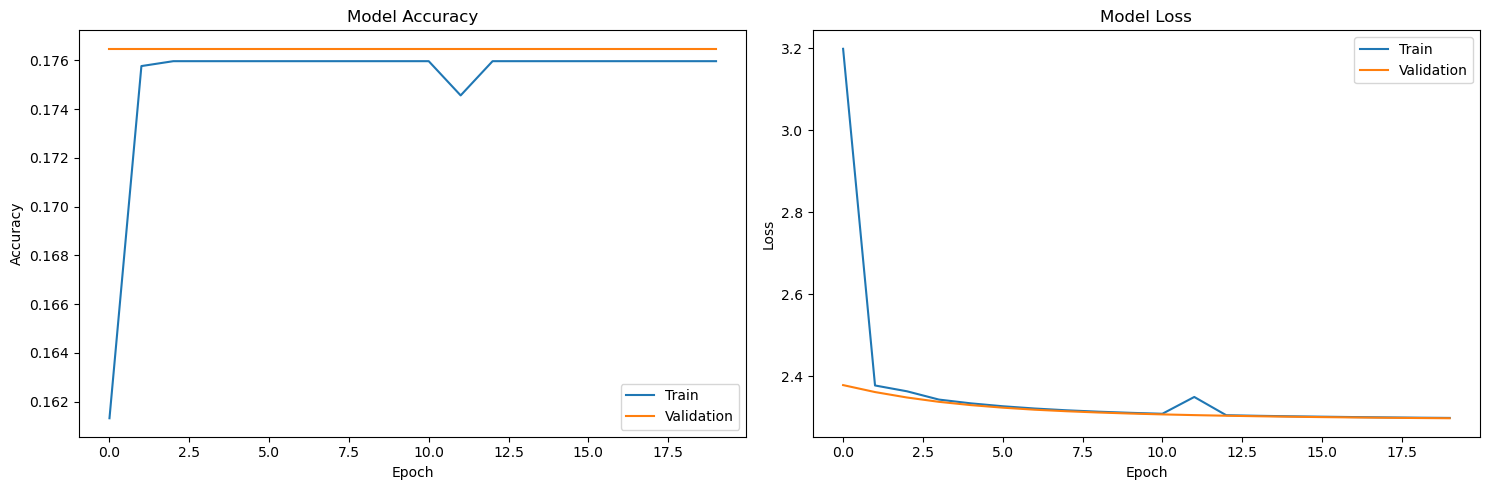

In [ ]:
# Train Transfer learning models using EfficientNetB0

models_to_try = ['VGG16', 'ResNet50', 'MobileNet', 'InceptionV3', 'EfficientNetB0']

model_name='EfficientNetB0'

#for model_name in models_to_try:
model = classifier.build_transfer_learning_model(model_name, num_classes)
out_model, history = classifier.train_model(model, train_gen, val_gen,epochs=epochs)
out_model.save('fish classification models saved'+model_name+'_model.h5')
report, conf_matrix = classifier.evaluate_model(val_gen)
model_results[model_name] = {
    'history': history,
    'report': report,
    'conf_matrix': conf_matrix
}

classifier.plot_training_history()